In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [4]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [5]:
zip_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True
)
csv_path, _= os.path.splitext(zip_path)

13574144/13568290 [==============================] - 1s 0us/step


In [6]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


- 데이터는 10분마다 기록된다. ( 1hours = 6, 1days = 144 )
- 특정 시간이 주어졌을 때, 앞으로 6시간 동안의 온도를 예측을 목표로 모델 설계
    - 예측을 하기 위해, 5일간의 데이터를 사용하도록 한다.
    - 모형을 학습하기 위해 720(5*144)개의 관측값이 포함된 window를 만든다.
    - 이러한 구성을 많이 만들 수 있기 때문에 데이터 세트를 실험하기에 적합하다.

In [17]:
def univariate_data(dataset, start_idx, end_idx, history_size, target_size):
    data = []
    labels = []
    
    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size
    
    for i in range(start_idx, end_idx):
        indices = range(i-history_size, i)
        
        data.append(np.reshape(dataset[indices].values, (history_size, 1)))
        labels.append(dataset[i+target_size])
    
    return np.array(data), np.array(labels)

- 해당 함수는 모델이 훈련 할 때 time window를 반환한다.
- history_size : 과거 information window의 크기 ( 몇 개의 과거 데이터를 학습할 것인지 )
- target_size : 예측해야하는 레이블이다. 얼마나 멀리있는 예측을 배워야 하는가이다.

In [9]:
# 30만개의 훈련데이터를 사용할 것이고, 나머지는 validation dataset 으로 사용할 것 이다.
# 2100일 분량의 train data가 해당된다.
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

In [10]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<AxesSubplot:xlabel='Date Time'>], dtype=object)

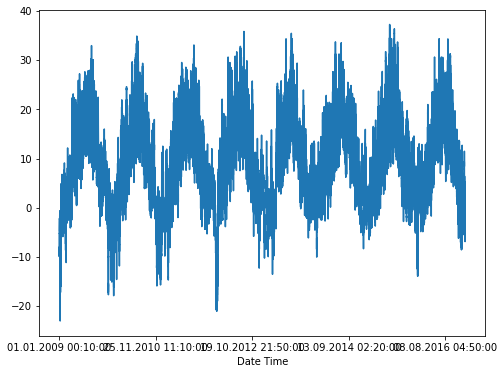

In [11]:
uni_data.plot(subplots=True)

- 신경망을 훈련하기 전 기능을 확장하는 것이 중요하다.
- 표준화는 평균을 빼고, 각 피처의 표준 편차로 나눔으로써 스케일링을 수행하는 일반적인 방법이다.
- tf.keras.utils.normalize 값은 [0,1] 범위로 재조정 하는 방법을 사용할 수 있다.
- 당연한거지만 평균 및 표준 편차는 훈련 데이터만을 사용하여 계산해야한다.

In [12]:
uni_data = uni_data.values

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [23]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data - uni_train_mean) / uni_train_std
uni_data

Date Time
01.01.2009 00:10:00   -1.997660
01.01.2009 00:20:00   -2.042816
01.01.2009 00:30:00   -2.054394
01.01.2009 00:40:00   -2.031237
01.01.2009 00:50:00   -2.026606
                         ...   
31.12.2016 23:20:00   -1.537995
31.12.2016 23:30:00   -1.456946
31.12.2016 23:40:00   -1.434947
31.12.2016 23:50:00   -1.558836
01.01.2017 00:00:00   -1.627149
Name: T (degC), Length: 420551, dtype: float64

In [48]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                          univariate_past_history,
                                          univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                      univariate_past_history,
                                      univariate_future_target)

In [47]:
print("Single window of past history")
print(x_train_uni[0])
print("\nTarget temperature to predict")
print(y_train_uni[0])

Single window of past history
[[-1.99765961]
 [-2.04281557]
 [-2.05439402]
 [-2.03123712]
 [-2.02660574]
 [-2.00113315]
 [-1.95134582]
 [-1.95134582]
 [-1.98492332]
 [-2.04513126]
 [-2.08334014]
 [-2.09723428]
 [-2.09376075]
 [-2.09144506]
 [-2.07176169]
 [-2.07176169]
 [-2.07639307]
 [-2.08912937]
 [-2.0926029 ]
 [-2.10418135]
 [-2.10418135]]

Target temperature to predict
-2.0949185930139698


In [25]:
def create_time_steps(length):
    return list(range(-length, 0))

In [26]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i,x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

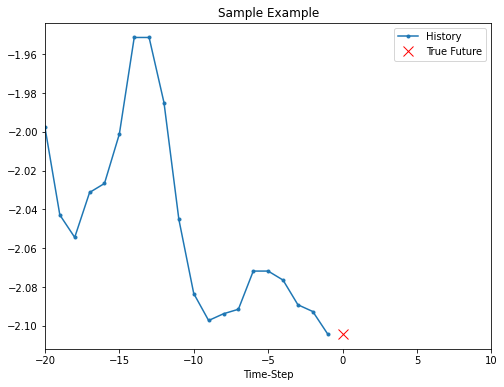

In [27]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

- 모델 학습을 진행하기 전 기준
- 입력 지점이 주어지면, 모든 기록을 보고 다음 지점이 마지막 20개 관측치의 평균이 될 것으로 예측한다.

In [28]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

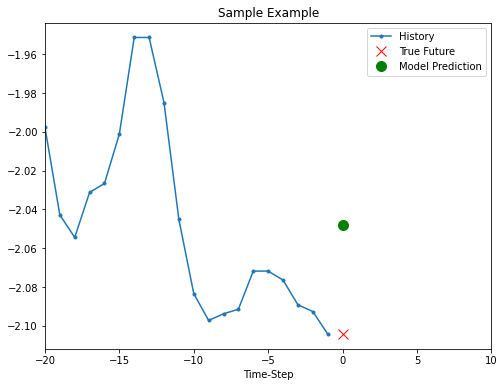

In [29]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Sample Example')

In [31]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni,
                                                      y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

- tf.data 데이터세트를 셔플, 배치 및 캐시하는데 사용한다.

In [33]:
train_univariate
val_univariate

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

In [45]:
x_train_uni.shape[-2:]

(20, 1)

In [37]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [38]:
for x,y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [40]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                     validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 3s 7ms/step - loss: 0.3409 - val_loss: 0.0672
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0711 - val_loss: 0.0315
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0412 - val_loss: 0.0273
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0382 - val_loss: 0.0259
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0287 - val_loss: 0.0236
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0307 - val_loss: 0.0220
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0275 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0260 - val_loss: 0.0193
Epoch 9/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0249 - val_loss: 0.0184
Epoch 10/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0225 - val_loss: 0.0169

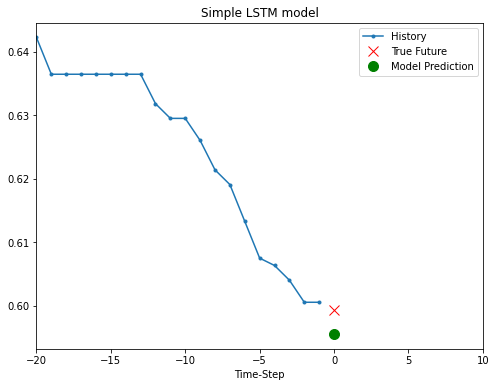

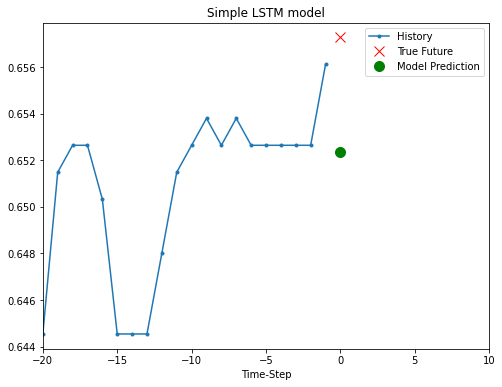

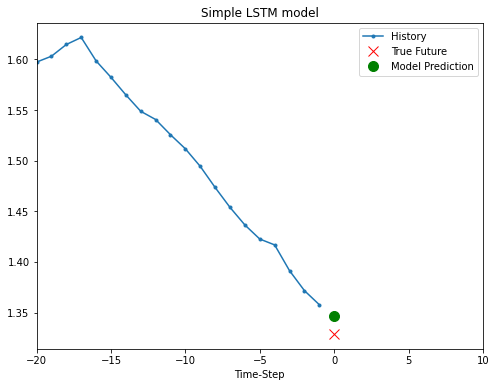

In [52]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                     simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

# Multivariate 시계열 예측
---
- 원본데이터 세트에는 14개의 특성이 있다. 14개 중 3개만 고려해보자.
- 사용되는 특성은 대기 온도, 대기압, 공기 밀도 이다.
- 더 많은 특성을 사용하려면 해당 특성 이름을 목록에 추가하자.

In [70]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [71]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

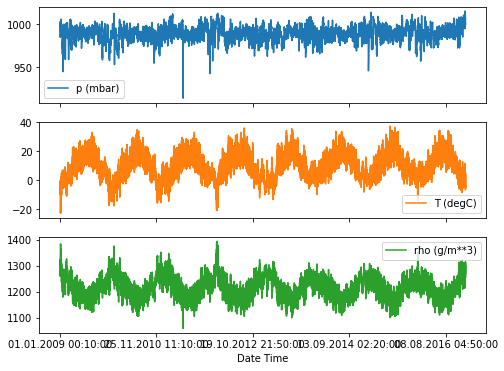

In [72]:
features.plot(subplots=True)

In [73]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

# 표준화
dataset = (dataset-data_mean)/data_std
dataset

array([[ 0.95547359, -1.99766294,  2.2350791 ],
       [ 0.96154485, -2.04281897,  2.28524007],
       [ 0.95668784, -2.05439744,  2.29600633],
       ...,
       [ 1.35617678, -1.43494935,  1.76136375],
       [ 1.35496252, -1.55883897,  1.88786728],
       [ 1.35617678, -1.62715193,  1.95686921]])

## Single step model
- 모델은 제공된 일부 이력을 기반으로 미래의 단일 지점을 예측하는 방법을 학습한다.
- 아래의 함수는 주어진 step_size를 기반으로 과거 관측치를 샘플링한다.

In [103]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
        
        
    return np.array(data), np.array(labels)

- 네트워크에 지난 5일 동안의 데이터, 즉 매 시간마다 샘플링되는 720개의 관측치가 표시된다.
- 60분 내에 급격한 변화가 예상되지 않으므로, 샘플링은 1시간마다 수행된다.
- 120개의 관측치는 지난 5일의 이력을 나타낸다.
- Single step model의 경우, 데이터 포인트의 레이블은 12시간 뒤의 온도이다.
    - 12시간 뒤의 온도 예측
    - 이를 위한 레이블을 만들기 위해 72(12 * 6) 관찰 후 온도가 사용된다.

In [104]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                  TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True
                                                  )
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                                  TRAIN_SPLIT, None, past_history,
                                                   future_target, STEP,
                                                   single_step=True
                                                  )

In [105]:
print("Single window of past history : {}".format(x_train_single[0].shape))

Single window of past history : (120, 3)


- 120 : 5일 * 24시간
- 3 : 3개의 특성

In [106]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [107]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(
    tf.keras.layers.LSTM(32,
                        input_shape=x_train_single.shape[-2:])
)
single_step_model.add(
    tf.keras.layers.Dense(1)
)
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                4608      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [108]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [109]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                           steps_per_epoch=EVALUATION_INTERVAL,
                                           validation_data=val_data_single,
                                           validation_steps=50)

Epoch 1/10
200/200 [==============================] - 10s 44ms/step - loss: 0.3168 - val_loss: 0.2584
Epoch 2/10
200/200 [==============================] - 8s 42ms/step - loss: 0.2620 - val_loss: 0.2521
Epoch 3/10
200/200 [==============================] - 9s 44ms/step - loss: 0.2630 - val_loss: 0.2477
Epoch 4/10
200/200 [==============================] - 9s 45ms/step - loss: 0.2598 - val_loss: 0.2389
Epoch 5/10
200/200 [==============================] - 9s 44ms/step - loss: 0.2279 - val_loss: 0.2324
Epoch 6/10
200/200 [==============================] - 9s 48ms/step - loss: 0.2403 - val_loss: 0.2664
Epoch 7/10
200/200 [==============================] - 8s 42ms/step - loss: 0.2437 - val_loss: 0.2579
Epoch 8/10
200/200 [==============================] - 9s 43ms/step - loss: 0.2406 - val_loss: 0.2514
Epoch 9/10
200/200 [==============================] - 8s 42ms/step - loss: 0.2432 - val_loss: 0.2527
Epoch 10/10
200/200 [==============================] - 9s 43ms/step - loss: 0.2409 - val_l

In [110]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

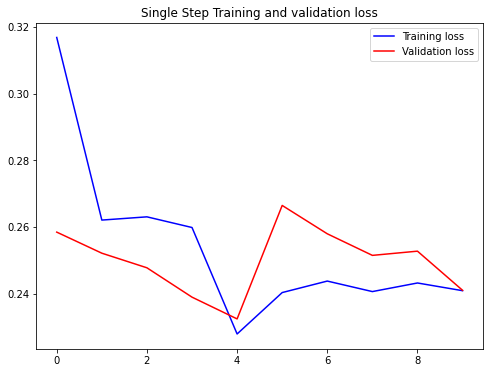

In [111]:
plot_train_history(single_step_history,
                  "Single Step Training and validation loss")

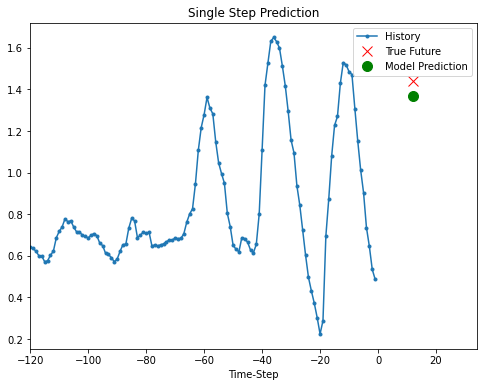

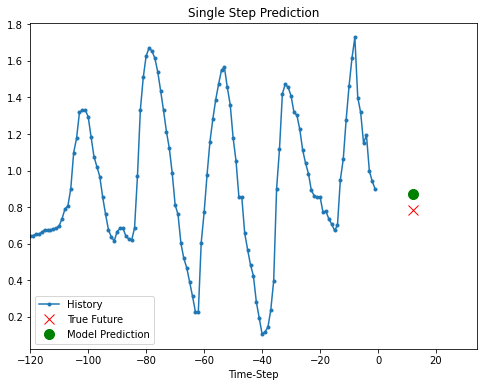

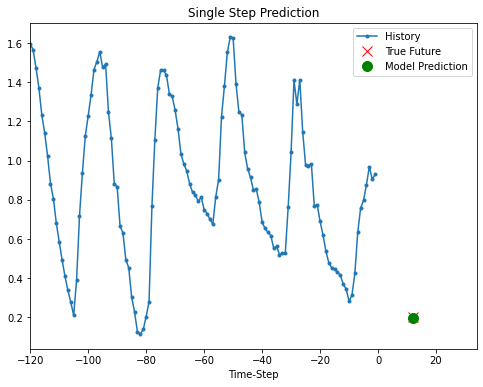

In [112]:
for x,y in val_data_single.take(3):
    plot = show_plot([x[0][:,1].numpy(), y[0].numpy(),
                     single_step_model.predict(x)[0]], 12,
                    'Single Step Prediction')
    plot.show()